# Load Libraries

In [32]:
# Standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Downsampling
from sklearn.utils import resample

# BoW Method
from sklearn.feature_extraction.text import TfidfVectorizer

# Model
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, precision_score

# Optimization
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

# Loading bar
from tqdm.notebook import tqdm

In [2]:
# Define a dictionary to go between class indices and class names
class_dict = { 'Hate Speech':0, 'Offensive Language':1, 'Neither':2 }
class_dict_inv = {value: key for key, value in class_dict.items()}

# Load Preprocessed Data with Features

In [3]:
df = pd.read_csv('parsed_data_with_features.csv')
# Drop the few indices where FRE was nan
df.dropna(axis='index', how='any', inplace=True)

# Downsampling

In [4]:
# Get the number of tweets for the class with fewest tweets
N_hate = np.sum(df['class']==0)
N_offensive = np.sum(df['class']==1)
N_neither = np.sum(df['class']==2)

class_names = ['Hate Speech', 'Offensive', 'Neither']
smallest_class_idx = np.argmin([N_hate,N_offensive,N_neither])
N_tweets_pr_class = np.array([N_hate,N_offensive,N_neither])[smallest_class_idx]

print(f'The class with fewest tweets is: {smallest_class_idx}={class_names[smallest_class_idx]}')
print(f'This class contains: {N_tweets_pr_class} tweets')

The class with fewest tweets is: 0=Hate Speech
This class contains: 1430 tweets


In [5]:
# Dataframe for Hate
hate_mask = (df['class'] == 0)
df_hate = df[hate_mask]

# Random Sampling of the larger classes
off_mask = (df['class'] == 1)
df_off = df[off_mask].sample(n=N_tweets_pr_class, replace=False, random_state=1, axis=0)

neither_mask = (df['class'] == 2)
df_neither = df[neither_mask].sample(n=N_tweets_pr_class, replace=False, random_state=1, axis=0)

# Put them together into a new dataframe
df_downsampled = pd.concat([df_hate, df_off, df_neither], axis=0)
df_downsampled.sort_values('Unnamed: 0', axis=0, ascending=True, inplace=True)

# Split Train/Test

In [6]:
# Extract X and Y
X = df_downsampled[['stemmed tweet', 'sentiment score', 'FRE score']]
Y = df_downsampled['class']

# Define test size
test_sz = 0.2

# Split up the sample
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_sz, random_state=1)

# Get stats from each sample
print('------------------TRAIN------------------')
print(f'Total tweets: {len(Y_train)}')
print(f'Hate speech tweets: { np.sum(Y_train==0) } \t {np.sum(Y_train==0)/len(Y_train)*100:.2f} %')
print(f'Offensive tweets: { np.sum(Y_train==1) } \t {np.sum(Y_train==1)/len(Y_train)*100:.2f} %')
print(f'Neither tweets: { np.sum(Y_train==2) } \t\t {np.sum(Y_train==2)/len(Y_train)*100:.2f} %')
print('\n')
print('------------------TEST-------------------')
print(f'Total tweets: {len(Y_test)}')
print(f'Hate speech tweets: { np.sum(Y_test==0) } \t {np.sum(Y_test==0)/len(Y_test)*100:.2f} %')
print(f'Offensive tweets: { np.sum(Y_test==1) } \t\t {np.sum(Y_test==1)/len(Y_test)*100:.2f} %')
print(f'Neither tweets: { np.sum(Y_test==2) } \t\t {np.sum(Y_test==2)/len(Y_test)*100:.2f} %')

------------------TRAIN------------------
Total tweets: 3432
Hate speech tweets: 1144 	 33.33 %
Offensive tweets: 1142 	 33.28 %
Neither tweets: 1146 		 33.39 %


------------------TEST-------------------
Total tweets: 858
Hate speech tweets: 286 	 33.33 %
Offensive tweets: 288 		 33.57 %
Neither tweets: 284 		 33.10 %


# TF-IDF on Train (.fit_transform) and Test (.transform)

In [7]:
# Initialise vectorizor
vectorizer = TfidfVectorizer(analyzer='word')

# Fit the vectorizor to the train data and transform the data accordingly
# NOTICE we use only the stemmed tweets for this part (since this is what we count words in)
Xt_train_tweets = vectorizer.fit_transform(X_train['stemmed tweet']).toarray()

# Get a dictionary mapping terms to indices
word_to_index = vectorizer.vocabulary_
# Invert it
index_to_word = {value: key for key, value in word_to_index.items()}
# Make column names into words
word_col_names = [ index_to_word[i] for i in np.arange(len(index_to_word)) ]
# Create data frame with the right col names
Xt_train_tweets = pd.DataFrame(Xt_train_tweets, columns=word_col_names, index=X_train['stemmed tweet'].index)

# Concatenate with the other features
other_features=['sentiment score', 'FRE score']
Xt_train = pd.concat([ Xt_train_tweets, X_train[[*other_features]] ], axis=1)

# Do the same on the test, but without the fitting part
Xt_test_tweets = vectorizer.transform(X_test['stemmed tweet']).toarray()
Xt_test_tweets = pd.DataFrame(Xt_test_tweets, columns=word_col_names, index=X_test['stemmed tweet'].index)
Xt_test = pd.concat([ Xt_test_tweets, X_test[[*other_features]] ], axis=1)

# GridSearch

In [51]:
# Define the pipeline including the selection method
pipe = Pipeline([ ('selection', SelectFromModel(LinearSVC(class_weight='balanced', penalty='l2',
                                                         loss='squared_hinge', multi_class='ovr',
                                                         max_iter=1e6), threshold=0.05) ),
                  ('model', LinearSVC(class_weight='balanced', penalty='l2', loss='squared_hinge',
                                     multi_class='ovr')) ])

# Define which parameters to investigate and in which interval
parameters_GridSearch = {'model__C': np.array([0.1,1,10])}

# Choose folds
k = 3

GridSearch = GridSearchCV(pipe,
                          param_grid=parameters_GridSearch,
                          cv=k,
                          return_train_score=True,
                          scoring='balanced_accuracy')

# Fit the grid search instance
GridSearch.fit(Xt_train, Y_train);

# Get results
GridSearch_results = pd.DataFrame(GridSearch.cv_results_)                 
print("Grid Search: \tBest parameters: ", GridSearch.best_params_, f", Best scores: {GridSearch.best_score_:.3f}")

GridSearch_results.head(3)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Grid Search: 	Best parameters:  {'model__C': 1.0} , Best scores: 0.779


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,287.385912,19.909878,0.150915,0.030738,0.1,{'model__C': 0.1},0.777835,0.783096,0.757872,0.772934,0.010865,2,0.861400,0.865328,0.874470,0.867066,0.005476
1,274.097834,32.003407,0.165632,0.047800,1,{'model__C': 1.0},0.789209,0.791838,0.756972,0.779339,0.015853,1,0.992126,0.983376,0.985128,0.986877,0.003780
2,280.575302,42.989770,0.122006,0.000034,10,{'model__C': 10.0},0.746380,0.748153,0.721985,0.738839,0.011940,3,0.998250,0.996061,0.995626,0.996646,0.001148


In [46]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'selection', 'model', 'selection__estimator__C', 'selection__estimator__class_weight', 'selection__estimator__dual', 'selection__estimator__fit_intercept', 'selection__estimator__intercept_scaling', 'selection__estimator__loss', 'selection__estimator__max_iter', 'selection__estimator__multi_class', 'selection__estimator__penalty', 'selection__estimator__random_state', 'selection__estimator__tol', 'selection__estimator__verbose', 'selection__estimator', 'selection__importance_getter', 'selection__max_features', 'selection__norm_order', 'selection__prefit', 'selection__threshold', 'model__C', 'model__class_weight', 'model__dual', 'model__fit_intercept', 'model__intercept_scaling', 'model__loss', 'model__max_iter', 'model__multi_class', 'model__penalty', 'model__random_state', 'model__tol', 'model__verbose'])

# Accuracy versus C

In [ ]:
# Wrapper Function for producing the model, selecting best features, returning the precision
def master_func(C_val):
    """
    C_param = value to chose for the regularization parameter C
    thres = the threshold to use for the SelectFromModel function
    
    """
    # Initialise model -----------------------------------
    model_test = LinearSVC(class_weight='balanced',C=C_val, penalty='l2', loss='squared_hinge',
                           multi_class='ovr', max_iter=1e4).fit(Xt_train, Y_train)
    
    # Drop worst features --------------------------------
    
    # SelectFromModel finds best features
    selector = SelectFromModel(model_test, prefit = True, threshold='0.3*mean')

    # Get a mask for extracting the chosen feature names
    mask = selector.get_support()
    best_feature_names = Xt_train.columns.values[mask]

    # Transform tweets by removing unwanted features
    Xt_train_best = selector.transform(Xt_train)
    Xt_test_best = selector.transform(Xt_test)

    # Make pandas with column names
    Xt_train_best = pd.DataFrame(Xt_train_best, columns=best_feature_names, index=X_train['stemmed tweet'].index)
    Xt_test_best = pd.DataFrame(Xt_test_best, columns=best_feature_names, index=X_test['stemmed tweet'].index)

    # Print how many is removed
    print(f'We have removed {len(Xt_train.columns)-len(Xt_train_best.columns)} features.')
    print(f'The total number of parameters is now {len(Xt_train_best.columns)}')
    
    # Train model -----------------------------------------
    # Initialise model
    model = LinearSVC(class_weight='balanced',C=0.1, penalty='l2', loss='squared_hinge', multi_class='ovr', max_iter=1e5)
    model.fit(Xt_train_best, Y_train)

    # Make predictions on the train data
    Y_train_preds = model.predict(Xt_train_best)
    
    # Model on Test ---------------------------------------
    # Make predictions on the test data
    Y_test_preds = model.predict(Xt_test_best)
    
    # Compute precisions (for each class) -----------------
    p_train = precision_score(Y_train, Y_train_preds, average=None)
    p_test = precision_score(Y_test, Y_test_preds, average=None)
    
    return p_train, p_test

In [29]:
master_func(C_val=0.1)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


We have removed 421 features.
The total number of parameters is now 5675


(array([0.8822335 , 0.8576481 , 0.85258359]),
 array([0.7704918 , 0.75170068, 0.79375   ]))

In [30]:
# Array of C's to try
N_search = 10
C_arr = np.linspace(0.01, 100, N_search)

# Empty array to store train and test precisions
p_train_arr = np.zeros( (3,N_search) )
p_test_arr = np.zeros( (3,N_search) )

# Loop
for i in tqdm(range(N_search)):
    
    # Compute precisions
    p_tr, p_te = master_func(C_arr[i])
    
    # Store vals
    p_train_arr[:,i] = p_tr
    p_test_arr[:,i] = p_te

  0%|          | 0/10 [00:00<?, ?it/s]

/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


We have removed 399 features.
The total number of parameters is now 5697


/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


We have removed 842 features.
The total number of parameters is now 5254


/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


We have removed 852 features.
The total number of parameters is now 5244


/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


We have removed 855 features.
The total number of parameters is now 5241


/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


We have removed 858 features.
The total number of parameters is now 5238


/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


We have removed 858 features.
The total number of parameters is now 5238


/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


We have removed 856 features.
The total number of parameters is now 5240


/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


We have removed 858 features.
The total number of parameters is now 5238


/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


We have removed 856 features.
The total number of parameters is now 5240


/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


We have removed 857 features.
The total number of parameters is now 5239


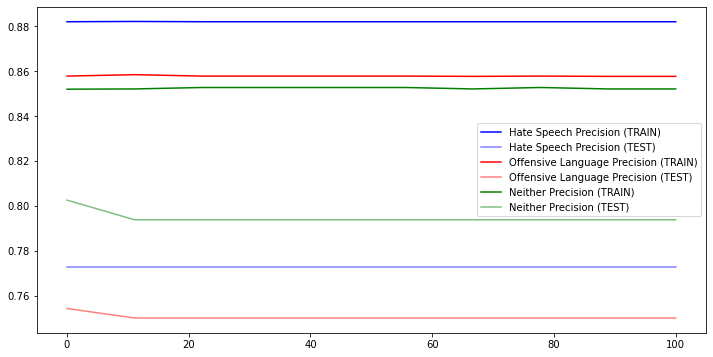

In [31]:
# Plotting
fig, ax = plt.subplots(figsize=(12,6))
colors = ['blue', 'red', 'green']

for i in range(3):

    ax.plot(C_arr, p_train_arr[i], color=colors[i], label=f'{class_dict_inv[i]} Precision (TRAIN)')
    ax.plot(C_arr, p_test_arr[i], color=colors[i], alpha=0.5, label=f'{class_dict_inv[i]} Precision (TEST)')

ax.legend()